In [1]:
import csv
import pickle
import json
import spacy
import re
import string
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

In [2]:
# Note that since tweets deviate from standard English (and other languages) and embody a unique "slang", this notebook "cleans" tweets manually and does not use any existing
# machinery from "really good" packages such as Spacy and NLTK; hence stop words from Gensim and listed here and removed as appropriate (This list is presented here since it 
# facilitates inclusion of additional stop words and removal if twitter meaning is being lost...)
stop_words = ['her', 'during', 'among', 'thereafter', 'only', 'hers', 'in', 'none', 'with', 'un', 'put', 'hence', 'each', 'would', 'have', 'to', 'itself', 'that', 'seeming', 
              'hereupon', 'someone', 'eight', 'she', 'forty', 'much', 'throughout', 'less', 'was', 'interest', 'elsewhere', 'already', 'whatever', 'or', 'seem', 'fire', 
              'however', 'keep', 'detail', 'both', 'yourselves', 'indeed', 'enough', 'too', 'us', 'wherein', 'himself', 'behind', 'everything', 'part', 'made', 'thereupon', 
              'for', 'nor', 'before', 'front', 'sincere', 'really', 'than', 'alone', 'doing', 'amongst', 'across', 'him', 'another', 'some', 'whoever', 'four', 'other', 
              'latterly', 'off', 'sometime', 'above', 'often', 'herein', 'am', 'whereby', 'although', 'who', 'should', 'amount', 'anyway', 'else', 'upon', 'this', 'when', 
              'we', 'few', 'anywhere', 'will', 'though', 'being', 'fill', 'used', 'full', 'thru', 'call', 'whereafter', 'various', 'has', 'same', 'former', 'whereas', 'what', 
              'had', 'mostly', 'onto', 'go', 'could', 'yourself', 'meanwhile', 'beyond', 'beside', 'ours', 'side', 'our', 'five', 'nobody', 'herself', 'is', 'ever', 'they', 'here', 
              'eleven', 'fifty', 'therefore', 'nothing', 'not', 'mill', 'without', 'whence', 'get', 'whither', 'then', 'no', 'own', 'many', 'anything', 'etc', 'make', 'from', 
              'against', 'ltd', 'next', 'afterwards', 'unless', 'while', 'thin', 'beforehand', 'by', 'amoungst', 'you', 'third', 'as', 'those', 'done', 'becoming', 'say', 'either', 
              'doesn', 'twenty', 'his', 'yet', 'latter', 'somehow', 'are', 'these', 'mine', 'under', 'take', 'whose', 'others', 'over', 'perhaps', 'thence', 'does', 'where', 
              'two', 'always', 'your', 'wherever', 'became', 'which', 'about', 'but', 'towards', 'still', 'rather', 'quite', 'whether', 'somewhere', 'might', 'do', 'bottom', 
              'until', 'km', 'yours', 'serious', 'find', 'please', 'hasnt', 'otherwise', 'six', 'toward', 'sometimes', 'of', 'fifteen', 'eg', 'just', 'a', 'me', 'describe', 
              'why', 'an', 'and', 'may', 'within', 'kg', 'con', 're', 'nevertheless', 'through', 'very', 'anyhow', 'down', 'nowhere', 'now', 'it', 'cant', 'de', 'move', 'hereby', 
              'how', 'found', 'whom', 'were', 'together', 'again', 'moreover', 'first', 'never', 'below', 'between', 'computer', 'ten', 'into', 'see', 'everywhere', 'there', 
              'neither', 'every', 'couldnt', 'up', 'several', 'the', 'i', 'becomes', 'don', 'ie', 'been', 'whereupon', 'seemed', 'most', 'noone', 'whole', 'must', 'cannot', 'per', 
              'my', 'thereby', 'so', 'he', 'name', 'co', 'its', 'everyone', 'if', 'become', 'thick', 'thus', 'regarding', 'didn', 'give', 'all', 'show', 'any', 'using', 'on', 
              'further', 'around', 'back', 'least', 'since', 'anyone', 'once', 'can', 'bill', 'hereafter', 'be', 'seems', 'their', 'myself', 'nine', 'also', 'system', 'at', 'more', 
              'out', 'twelve', 'therein', 'almost', 'except', 'last', 'did', 'something', 'besides', 'via', 'whenever', 'formerly', 'cry', 'one', 'hundred', 'sixty', 'after', 
              'well', 'them', 'namely', 'empty', 'three', 'even', 'along', 'because', 'ourselves', 'such', 'top', 'due', 'inc', 'themselves']

In [3]:
# read in tweet train data from csv file
tw = pd.read_csv('D:\\Data\\Tweet\\training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)
tw.columns = ['sentiment', 'index', 'date/time', 'query', 'user', 'tweet']

In [4]:
# display head entries
tw.head()

,sentiment,index,date/time,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# display tail entries
tw.tail()

,sentiment,index,date/time,query,user,tweet
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [6]:
# convert data to numpy arrays
tweets = tw['tweet'].values
labels = tw['sentiment'].values
print("Extracted {} tweets and {} labels...".format(tweets.shape[0], labels.shape[0]))

Extracted 1600000 tweets and 1600000 labels...


In [7]:
# method to strip all entities from tweet - users, handles
def strip_all_entities(text):
    entity_prefixes = ['@','#']
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [8]:
# clean tweets - remove users, handles, punctuation, numbers, urls
# note tested lemmatization with Spacy but had little effect (so not included here)

punctuations = '''()-[]{};:"\,<>./?@#$%^&_~'''             # masks to remove all punctuation except for ! and * and '
numbers = '''0123456789'''                                 # mask to remove all numbers

tweet_words = []
for idx, tweet in enumerate(tweets):
    # print(tweet)
    tweet = str(tweet)
    tweet = re.sub(r'http\S+', '', tweet.strip())          # remove urls
    tweet = strip_all_entities(tweet).lower()              # remove entities
    for t in tweet:
        if t in punctuations or t in numbers:
            tweet = tweet.replace(t, " ")                  # non-regex removal of selected punctuation and numbers
    tweet = re.sub('\s+',' ', tweet.strip())               # remove extra whitespace from punctuation removal 
    tweet_words.append(tweet.split(' '))
    tweets[idx] = tweet

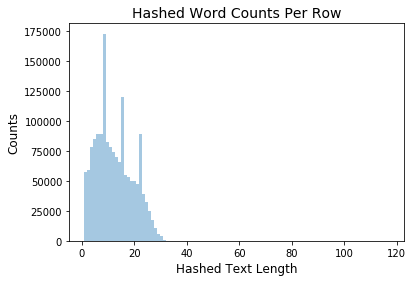

In [9]:
# find distribution of words per tweet to set record length for training vectors
word_counts_per_row = []
max_row_len = 0

for idx, tweet in enumerate(tweets):        
    try:
        words = tweet.split(' ')
        wlen = len(words)
        word_counts_per_row.append(wlen)
    except AttributeError:
         print("AttributeError at idx: ", idx)
    
sns.distplot(word_counts_per_row, kde=False, bins=100)
plt.title('Hashed Word Counts Per Row', fontsize=14)
plt.xlabel('Hashed Text Length', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.show()

In [10]:
# method to form word clouds from text
def word_cloud(tweet_dict):
    # generate the wordcloud using the series created and the mask 
    wc = WordCloud(width=2000, height=1000, max_font_size=200,  background_color="black", max_words=500, contour_width=1, contour_color="steelblue", colormap="nipy_spectral")
    wc.generate_from_frequencies(tweet_dict)

    plt.figure(figsize=(20,10))
    # plt.imshow(wc, interpolation="bilinear")
    plt.imshow(wc, interpolation="hermite")
    plt.axis("off")    
    plt.show()   

In [11]:
# extract positive and negative tweets
positive_tweets = []
neutral_tweets = []
negative_tweets = []
for idx, tweet in enumerate(tweets):
    if labels[idx] == 0:
        negative_tweets.append(tweet)
    elif labels[idx] == 2:
        neutral_tweets.append(tweet)
    elif labels[idx] == 4:
        positive_tweets.append(tweet)
        
print("There are {} positive, {} neutral and {} negative tweets...".format(len(positive_tweets), len(neutral_tweets), len(negative_tweets)))
# print(positive_tweets[0:20])

There are 800000 positive, 0 neutral and 800000 negative tweets...


In [12]:
# method to create word frequency dict from list of tweets
def word_dict(tweets):
    words = {}
    for tweet in tweets:
        text = tweet.split(' ')
        for t in text:
            if t in stop_words:
                continue
            if t in words:
                words[t] += 1
            else:
                words[t] = 1
    return {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}

In [13]:
# determine word frequency in positive and negative tweets
positive_word_dict = word_dict(positive_tweets)
negative_word_dict = word_dict(negative_tweets)

Positive Tweets


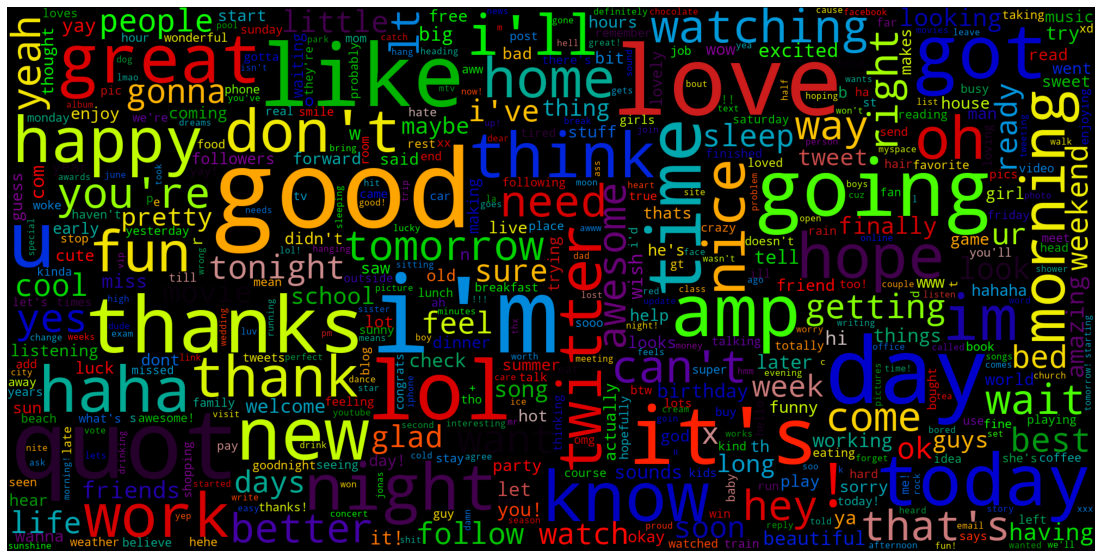

Negative Tweets


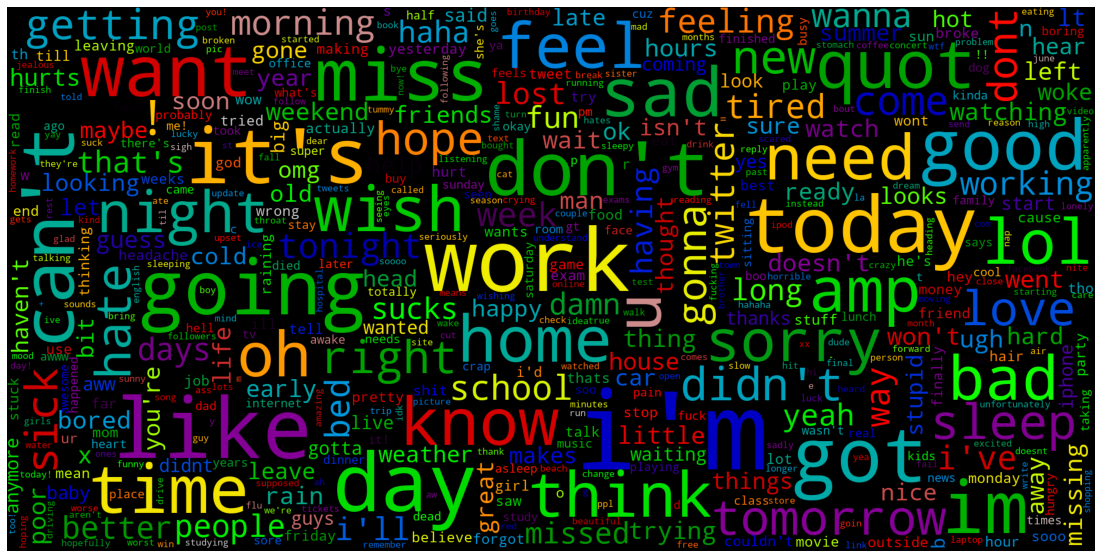

In [14]:
# show word cloud for positive and negative tweets
print("Positive Tweets")
word_cloud(positive_word_dict)
print("Negative Tweets")
word_cloud(negative_word_dict)

In [15]:
# method to show word frequencies in tweet dicts
def show_frequencies(tweet_dict, dict_name):
    labels = list(tweet_dict.keys())
    values = list(tweet_dict.values())
    title = "Word Frequency for {}".format(dict_name)
    
    plt.figure(figsize=(20, 10))
    plt.bar(np.arange(50), values[0: 50], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, edgecolor = "black", capsize=8, linewidth=1)
    plt.xticks(np.arange(50), labels[0: 50], rotation=90, size=14)
    plt.xlabel("Most Frequent Words", size=14)
    plt.ylabel("Frequency", size=14)
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

Positive Tweets


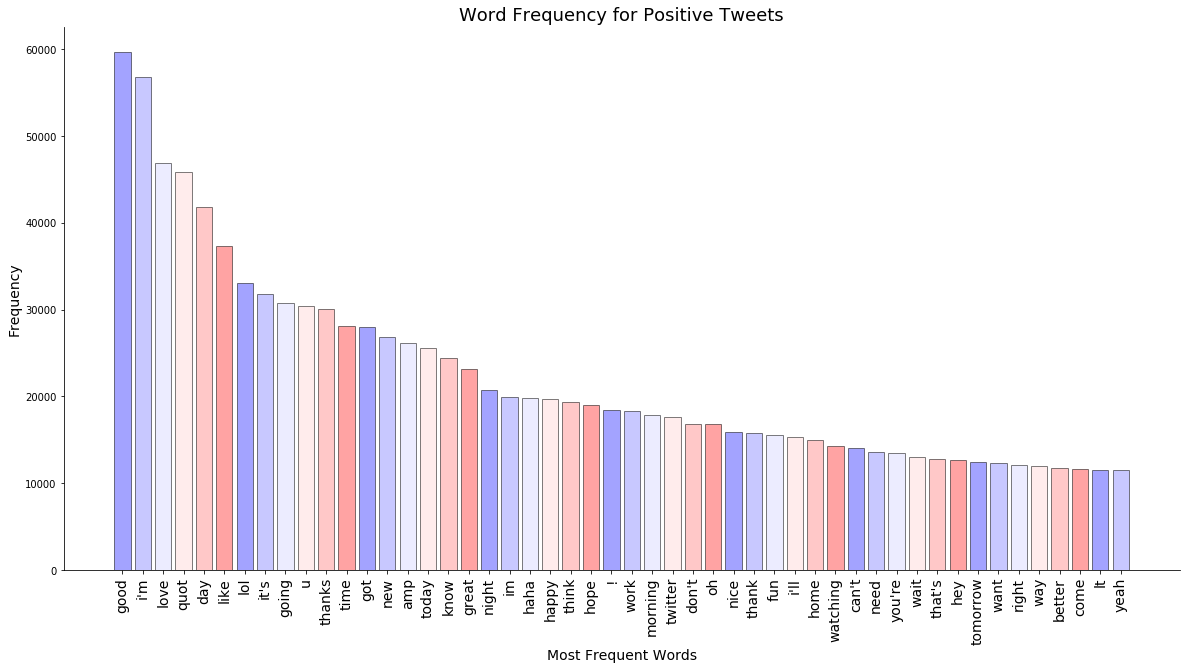

Negative Tweets


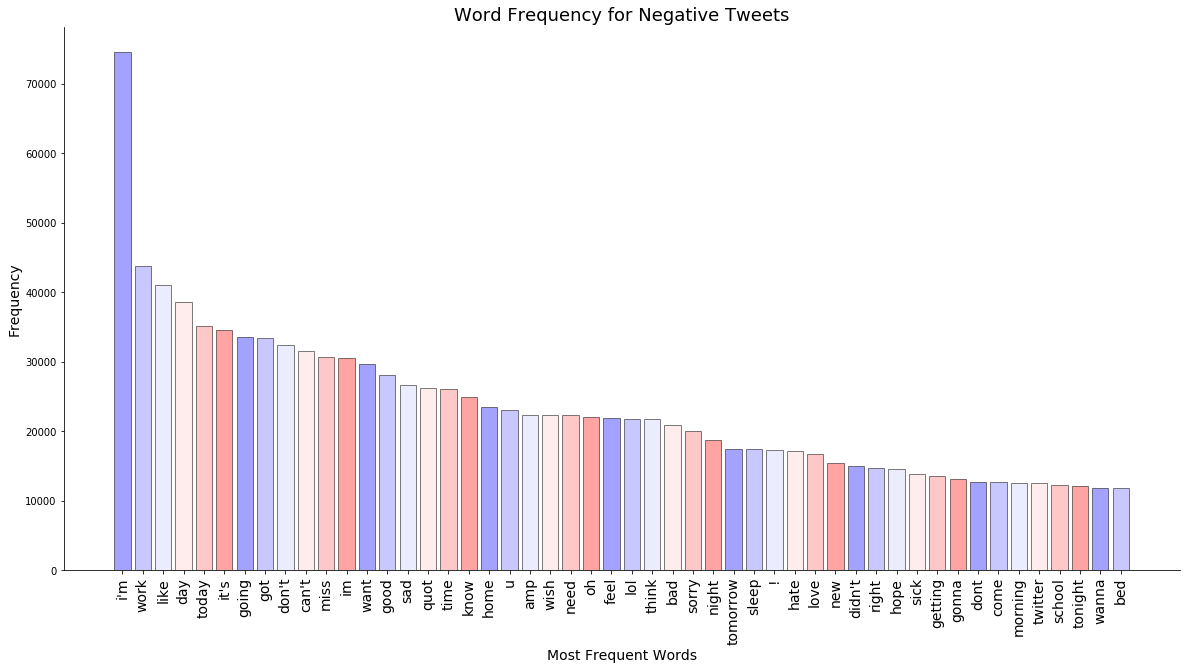

In [16]:
# show word frequency plots for positive and negative tweets
print("Positive Tweets")
show_frequencies(positive_word_dict, "Positive Tweets")
print("Negative Tweets")
show_frequencies(negative_word_dict, "Negative Tweets")

In [17]:
# method to show correlation between word frequencies in positive and negative tweets
def correlation_plot(table):
    table = table[1:]
    sns.set_style("whitegrid")   
    plt.figure(figsize=(12, 10))
    points = plt.scatter(table["positive"], table["negative"], c=table["positive"], s=75, cmap="bwr")
    plt.colorbar(points)
    sns.regplot(x="positive", y="negative",fit_reg=False, scatter=False, color=".1", data=table)
    plt.xlabel("Frequency for Positive Tweets", size=14)
    plt.ylabel("Frequency for Negative Tweets", size=14)
    plt.title("Word Frequency Correlation - Positive Negative Tweets", size=14)
    plt.grid(False)
    sns.despine()

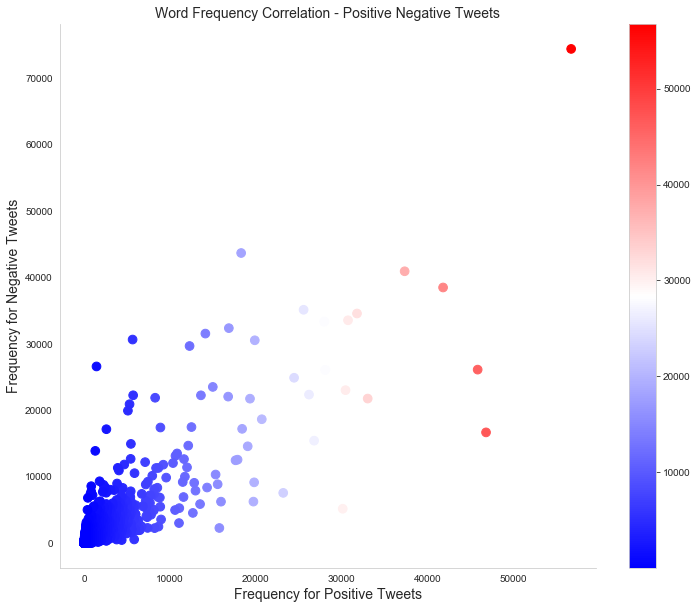

In [18]:
pos = pd.DataFrame(positive_word_dict.items())
pos.columns = ['word', 'positive']
neg = pd.DataFrame(negative_word_dict.items())
neg.columns = ['word', 'negative']
corr = pd.merge(pos, neg, on='word').drop(['word'], axis=1)
correlation_plot(corr)

<h4>Preprocess Data for Sentiment Training</h4>
<ol>
    <li>Create Tokenization and Label Index Dicts and save to files</li>
    <li>Tokenize each row in training dataset</li>
    <li>Truncate/Pad each row to fixed length and Create Label (with 0 or 1 value) per Row for Training BCE for each label</li>
</ol>

In [19]:
import torch
import transformers
# from transformers import BertModel, BertTokenizer, AdamW
from transformers import DistilBertTokenizer, DistilBertModel, AdamW

# PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'
# from distplot, set max tokens
MAX_TOKENS = 32 + 2          # two stop tokens added
# checkpoint file
checkpoint_file = 'C:\\Users\\Barnwaldo\\Documents\\Labs\\Tweets\\checkpoint.pt'

# Use pre-trained BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
   
encoding_ids = []
attention_mask = []
ylabels = []

positive_ctr = 0
negative_ctr = 0

for idx, tweet in enumerate(tweets):
    enc = tokenizer.encode(tweet, add_special_tokens=True)
    msk = [1] * MAX_TOKENS
    num_tokens = len(enc)
    if num_tokens < MAX_TOKENS:
        msk = [1] * num_tokens + [0] * (MAX_TOKENS - num_tokens)
        enc = enc + [0] * (MAX_TOKENS - num_tokens)
    elif num_tokens > MAX_TOKENS:
        enc = enc[0: MAX_TOKENS]
    # add torch tensor to list
    encoding_ids.append(torch.LongTensor(enc))
    attention_mask.append(torch.LongTensor(msk))
    
    # one hot encode labels (use three columns so every label has its own)
    if labels[idx] == 4:
        ylabels.append(torch.zeros(1, dtype=torch.float))
        positive_ctr += 1
    else:
        ylabels.append(torch.ones(1, dtype=torch.float))
        negative_ctr += 1

print(encoding_ids[2])
print(attention_mask[2])
        
print("Number of positive labels: {} -- Number of negative labels: {}".format(positive_ctr, negative_ctr))

tensor([  101,   178, 12706,  1181,  1242,  1551,  1111,  1103,  3240,  2374,
         1106,  3277,  1103,  1832,  1301,  1149,  1104, 22379,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Number of positive labels: 800000 -- Number of negative labels: 800000


In [20]:
import torch.nn as nn

class TweetClassifier(nn.Module):

    def __init__(self, num_features=34, num_classes=1):
        super(TweetClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.dense1 = nn.Linear(self.bert.config.hidden_size, 1)
        self.flatten = nn.Flatten()
        self.dense2 = nn.Linear(num_features, num_classes)

    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # print(out[0].shape)
        out = self.drop(out[0])
        out = self.dense1(out)
        out = self.flatten(out)
        out = self.dense2(out)
        # print(out.shape)
        return out

In [21]:
from sklearn.model_selection import train_test_split
# split training data for test and validation
seed = 42
np.random.seed(seed)
EPOCHS = 3
BATCH_SIZE = 128
TEST_SIZE = 0.2
# Split training data 80/20 train/test split
enc_train, enc_val, msk_train, msk_val, ylab_train, ylab_val = train_test_split(encoding_ids, attention_mask, ylabels, test_size=TEST_SIZE, random_state=seed)

In [22]:
# Train/validate model
model = TweetClassifier()
device = 'cpu'
if torch.cuda.is_available():
    model = model.cuda()
    device = 'cuda:' + str(torch.cuda.current_device())
    
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
# print(model)

In [ ]:
num_train_batches = int((1.0 - TEST_SIZE) * len(tweets) / BATCH_SIZE)
num_val_batches = int(TEST_SIZE * len(tweets) / BATCH_SIZE)

torch.set_printoptions(threshold=10_000)

history = []
for epoch in range(EPOCHS):
        
    model.train()
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    
    for idx in range(num_train_batches):
        optimizer.zero_grad()
        print('.', end="")
        offset = idx * BATCH_SIZE
        X_enc = torch.stack(tuple(enc_train[offset: offset + BATCH_SIZE]), dim=0).to(device)
        X_msk = torch.stack(tuple(msk_train[offset: offset + BATCH_SIZE]), dim=0).to(device)
        targets = torch.stack(tuple(ylab_train[offset: offset + BATCH_SIZE]), dim=0).to(device)
        # print(X_enc.shape, X_msk.shape, targets.shape)
        # print(X_enc.dtype, X_msk.dtype, targets.dtype)
        outputs = model(X_enc, X_msk)     
        loss = criterion(outputs, targets)
        # print(outputs.shape, targets.shape)
        # print("LOSS:", loss)
        # print(loss.dtype)
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
        outputs = torch.round(torch.sigmoid(outputs))
        correct = (outputs == targets).sum().item()
        total = targets.shape[0]
        if total > 1.0:
            acc = correct / total
            train_acc_list.append(acc)
            
        if idx == 0:
            continue
        if (idx + 1) % 1000 == 0:
            print('\n')
            print("-------------------------------------------------------------------------------------------------------")
            print("Epoch [{}/{}], Step [{}/{}], Avg Loss: {:.4f}, Avg Acc: {:.4f}"
                  .format(epoch + 1, EPOCHS, idx + 1, num_train_batches, sum(train_loss_list) / len(train_loss_list), sum(train_acc_list) / len(train_acc_list)))
            print("-------------------------------------------------------------------------------------------------------")
       
    print(" ")
    model.eval()
    with torch.no_grad():
        for idx in range(num_val_batches):
            print('-', end="")
            offset = idx * BATCH_SIZE
            X_enc = torch.stack(tuple(enc_val[offset: offset + BATCH_SIZE]), dim=0).to(device)
            X_msk = torch.stack(tuple(msk_val[offset: offset + BATCH_SIZE]), dim=0).to(device)
            targets = torch.stack(tuple(ylab_val[offset: offset + BATCH_SIZE]), dim=0).to(device)
            outputs = model(X_enc, X_msk)
        
            loss = criterion(outputs, targets)
            # print("LOSS:", loss)
            val_loss_list.append(loss.item())
            outputs = torch.round(torch.sigmoid(outputs))
            correct = (outputs == targets).sum().item()
            total = targets.shape[0]
            if total > 1.0:
                acc = correct / total
                val_acc_list.append(acc)
            
            if idx == 0:
                continue
            if (idx + 1) % 1000 == 0:
                print('\n')
                print("-------------------------------------------------------------------------------------------------------")
                print("TEST -- Avg Loss: {:.4f}, Avg Acc: {:.4f}"
                      .format(sum(val_loss_list) / len(val_loss_list), sum(val_acc_list) / len(val_acc_list)))
                print("-------------------------------------------------------------------------------------------------------")
    
    results = {}
    results['epoch'] = epoch + 1
    results['loss'] = sum(train_loss_list) / len(train_loss_list)
    results['acc'] = sum(train_acc_list) / len(train_acc_list)
    results['val_loss'] = sum(val_loss_list) / len(val_loss_list)
    results['val_acc'] = sum(val_acc_list) / len(val_acc_list)
    
    # save model, optimizer, etc., at end of each epoch (checkpoint)
    torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': loss}, checkpoint_file)
    if epoch > 0: 
        history.append(results)


In [28]:
# have copied history for three epics from very long output (that was cleared so that notebook can be followed)
epoch = [1, 2, 3]
loss = [0.3609,  0.3112, 0.2724]
acc = [0.8393, 0.8655, 0.8847]
val_loss = [0.3411, 0.3429 , 0.3631]
val_acc = [0.8520, 0.8542, 0.8519]

history = [{'epoch': 1, 'loss': 0.3609, 'acc': 0.8393, 'val_loss': 0.3411, 'val_acc': 0.8520}, 
           {'epoch': 2, 'loss': 0.3112, 'acc': 0.8655, 'val_loss': 0.3429, 'val_acc': 0.8542}, 
           {'epoch': 3, 'loss': 0.2724, 'acc': 0.8847, 'val_loss': 0.3631, 'val_acc': 0.8519}]

print("Output after {} epochs: Acc={:.2f}%, Val_Acc={:.2f}%".format(epoch[2], 100 * acc[2], 100 * val_acc[2]))

Output after 3 epochs: Acc=88.47%, Val_Acc=85.19%


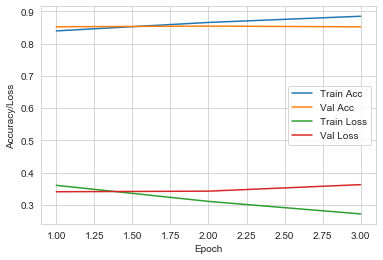

In [29]:
# plot model history
plt.plot(epoch, acc,      label='Train Acc')
plt.plot(epoch, val_acc,  label='Val Acc')
plt.plot(epoch, loss,     label='Train Loss')
plt.plot(epoch, val_loss, label='Val Loss')
 
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.legend()
plt.show()